# Importing Packages

In [1]:
!pip install tensorflow==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.4 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [3]:
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Importing

In [4]:
data_dir = "/kaggle/input/handwritten-marathi-character-augmented-dataset/Alphabets"
data_dir = pathlib.Path(data_dir)
print(data_dir)

/kaggle/input/handwritten-marathi-character-augmented-dataset/Alphabets


/kaggle/input/handwritten-marathi-character-augmented-dataset/Alphabets/C5/C5_61.jpg


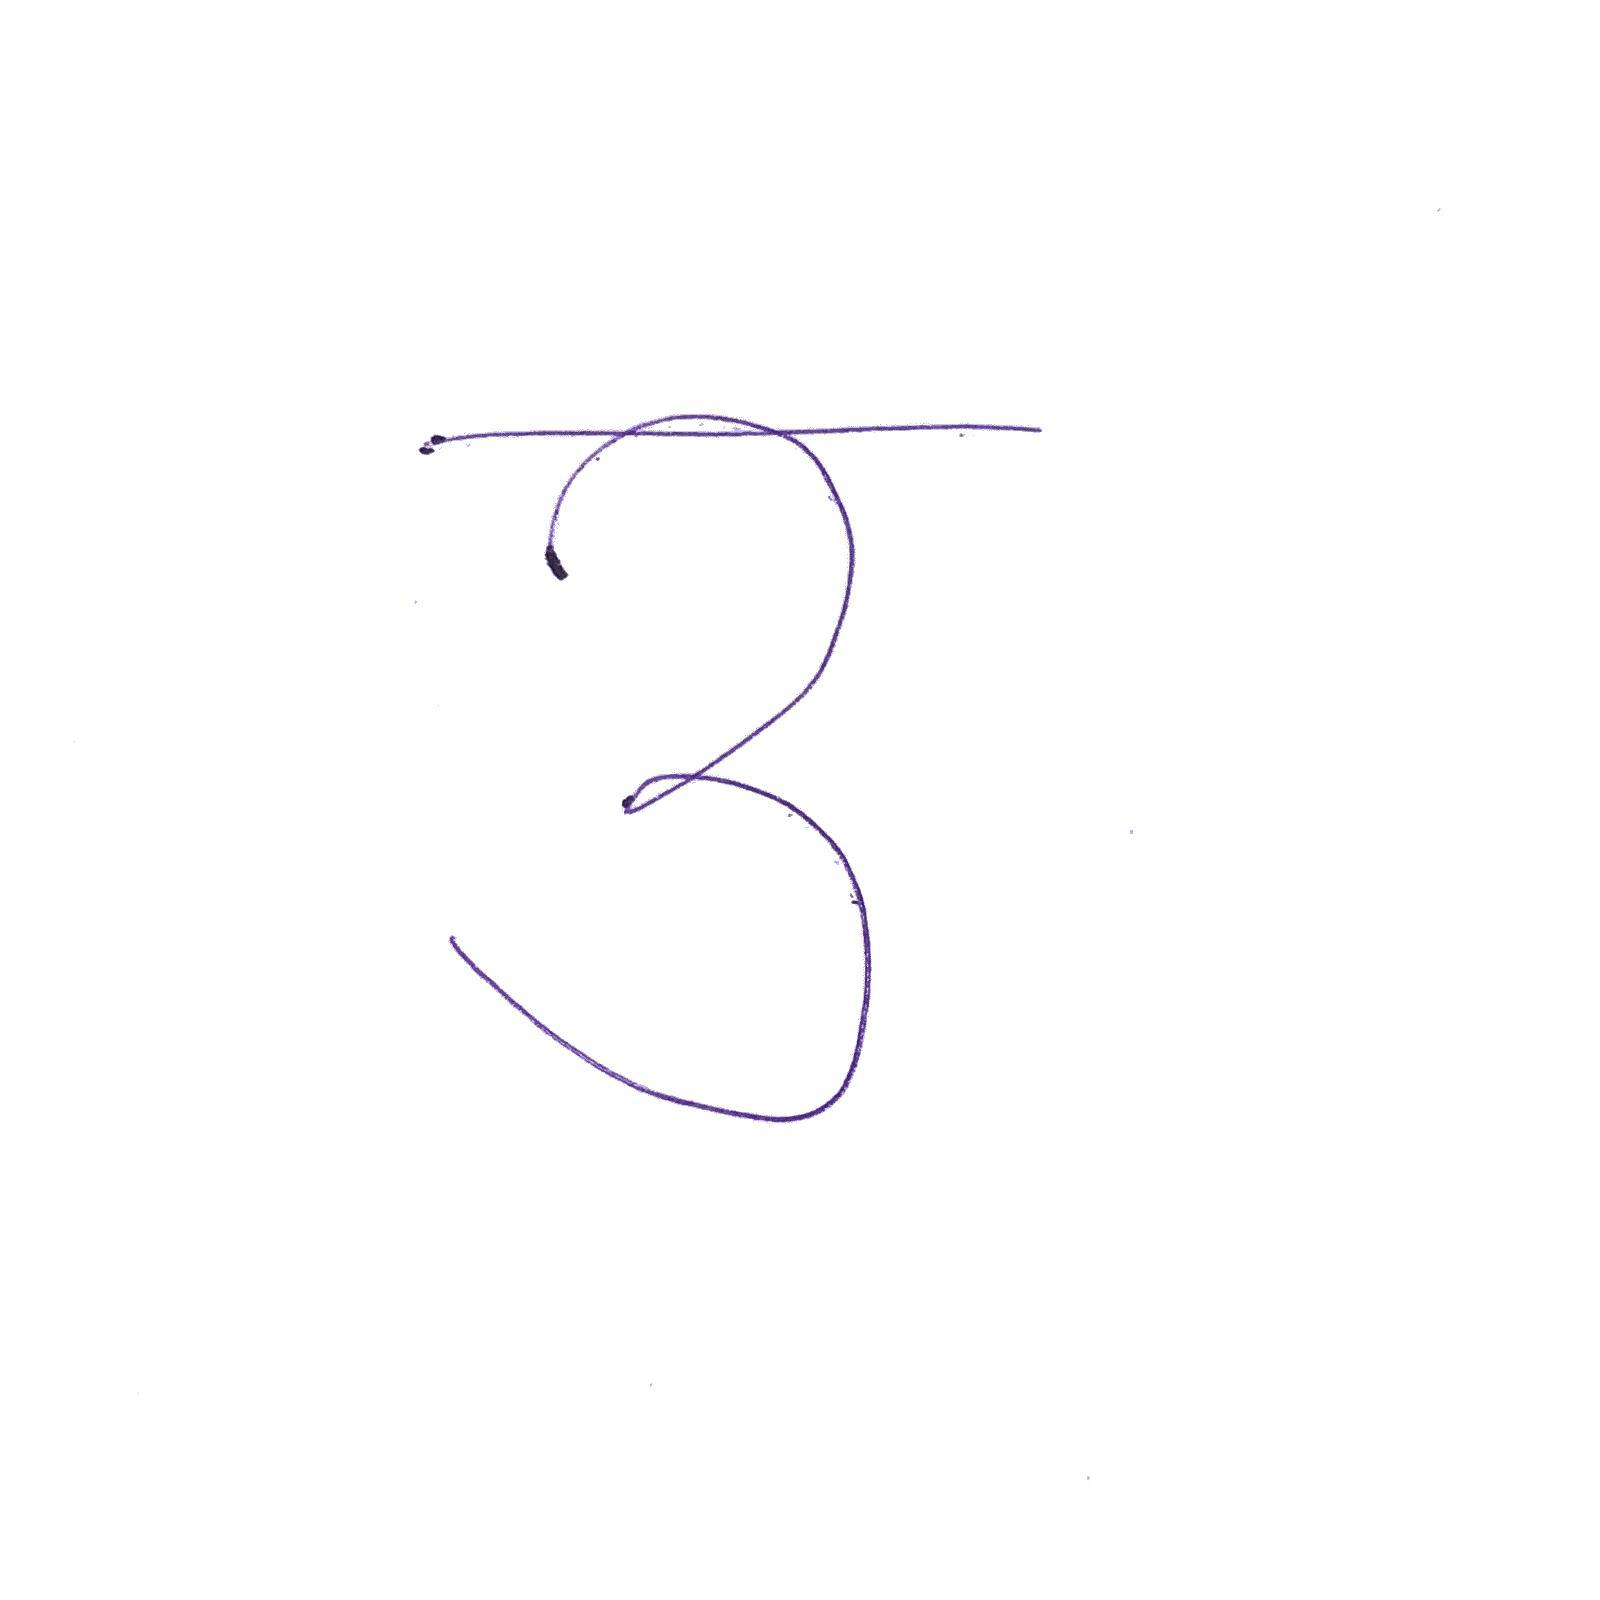

In [5]:
ch1 = list(data_dir.glob('C5/*'))
print(ch1[0])
PIL.Image.open(str(ch1[0]))

# Data Augmentation

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height,img_width=224,224
batch_size =32

# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)

# Prepare training dataset with data augmentation
train_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=123
)

# Prepare validation dataset without data augmentation
val_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=123
)

Found 21600 images belonging to 48 classes.
Found 7200 images belonging to 48 classes.


In [7]:
class_indices = train_ds.class_indices
class_names = {v: k for k, v in class_indices.items()}
print(class_names)

{0: 'C1', 1: 'C10', 2: 'C11', 3: 'C12', 4: 'C13', 5: 'C14', 6: 'C15', 7: 'C16', 8: 'C17', 9: 'C18', 10: 'C19', 11: 'C2', 12: 'C20', 13: 'C21', 14: 'C22', 15: 'C23', 16: 'C24', 17: 'C25', 18: 'C26', 19: 'C27', 20: 'C28', 21: 'C29', 22: 'C3', 23: 'C30', 24: 'C31', 25: 'C32', 26: 'C33', 27: 'C34', 28: 'C35', 29: 'C36', 30: 'C37', 31: 'C38', 32: 'C39', 33: 'C4', 34: 'C40', 35: 'C41', 36: 'C42', 37: 'C43', 38: 'C44', 39: 'C45', 40: 'C46', 41: 'C47', 42: 'C48', 43: 'C5', 44: 'C6', 45: 'C7', 46: 'C8', 47: 'C9'}


# Develop Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
# Load ResNet50
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# Model modification
model = Sequential([
    base_model,    
    # Here, we introduce additional  layers.
    Conv2D(256, (3, 3), activation='relu', padding='same'),  # Add additional Conv2D layer
    BatchNormalization(),  # Add BatchNormalization layer
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(1024, activation="relu"),  # A dense layer with 1024 units and 'relu' activation.
    Dropout(0.5),                     # A dropout layer for regularization (optional).
    Dense(512, activation="relu"),   # Another dense layer with 512 units.
    Dropout(0.5),                     # Another dropout layer for regularization (optional).
    
    Dense(len(train_ds.class_indices), activation="softmax")
])
# Define the learning rate
learning_rate = 0.001  # You can adjust this value as needed

# Create the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         4718848   
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 256)         1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 256)         0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 3, 3, 256)         0         
                                                                 
 global_average_pooling2d_1  (None, 256)              

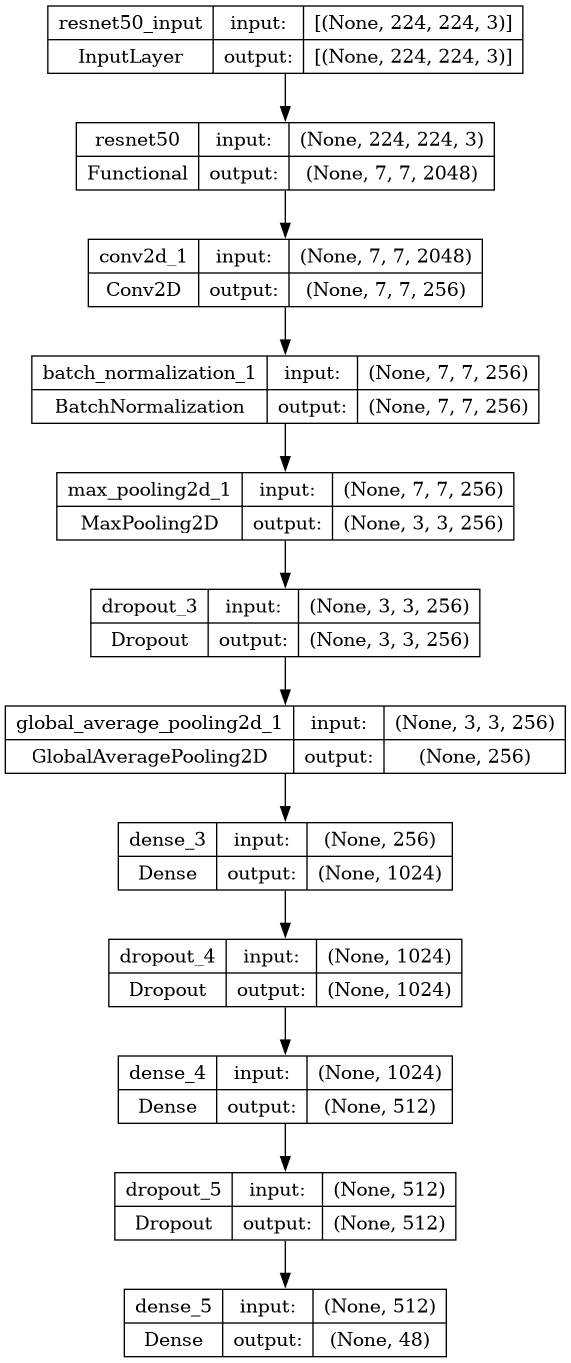

In [11]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Train Model

In [12]:
# creating checkpoints
model_path = "/kaggle/working/MCCR_best_model_M3_V1.keras"

# Define the checkpoint
checkpoint = ModelCheckpoint(model_path, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")


In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint]   
)

Epoch 1/20


2024-04-01 18:34:53.720268: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1711996499.057632     132 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


675/675 [==============================] - ETA: 0s - loss: 3.0079 - accuracy: 0.1322
Epoch 1: val_accuracy improved from -inf to 0.02083, saving model to /kaggle/working/MCCR_best_model_M3_V1.keras
675/675 [==============================] - 447s 605ms/step - loss: 3.0079 - accuracy: 0.1322 - val_loss: 10.2192 - val_accuracy: 0.0208
Epoch 2/20
675/675 [==============================] - ETA: 0s - loss: 1.3408 - accuracy: 0.5441
Epoch 2: val_accuracy improved from 0.02083 to 0.32472, saving model to /kaggle/working/MCCR_best_model_M3_V1.keras
675/675 [==============================] - 283s 419ms/step - loss: 1.3408 - accuracy: 0.5441 - val_loss: 2.9222 - val_accuracy: 0.3247
Epoch 3/20
675/675 [==============================] - ETA: 0s - loss: 0.5738 - accuracy: 0.8160
Epoch 3: val_accuracy improved from 0.32472 to 0.62194, saving model to /kaggle/working/MCCR_best_model_M3_V1.keras
675/675 [==============================] - 285s 422ms/step - loss: 0.5738 - accuracy: 0.8160 - val_loss: 1.

# Model Evaluation

In [14]:
from tensorflow.keras.models import load_model
best_model = load_model('/kaggle/working/MCCR_best_model_M3_V1.keras')

In [15]:
test_dir = '/kaggle/input/testingdataset/Alphabets'

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 1918 images belonging to 48 classes.


In [16]:
result = best_model.evaluate(test_data)
print(result)

60/60 [==============================] - 14s 206ms/step - loss: 29.9951 - accuracy: 0.1246
[29.995128631591797, 0.12460897117853165]


In [17]:
from sklearn.metrics import classification_report
import numpy as np

# Predict the labels for the testing dataset
y_pred = best_model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels from the validation dataset generator
val_true_labels = test_data.classes

# Convert one-hot encoded labels to class labels
val_class_labels = list(val_ds.class_indices.keys())

# Generate classification report
classification_rep = classification_report(val_true_labels, y_pred_classes, target_names=val_class_labels)

print("Classification Report:")
print(classification_rep)

60/60 [==============================] - 6s 82ms/step
Classification Report:
              precision    recall  f1-score   support

          C1       0.00      0.00      0.00        40
         C10       0.01      0.03      0.02        40
         C11       0.00      0.00      0.00        40
         C12       0.03      0.05      0.03        40
         C13       0.00      0.00      0.00        40
         C14       0.03      0.12      0.05        40
         C15       0.00      0.00      0.00        40
         C16       0.00      0.00      0.00        40
         C17       0.00      0.00      0.00        40
         C18       0.00      0.00      0.00        40
         C19       0.00      0.00      0.00        40
          C2       0.00      0.00      0.00        40
         C20       0.00      0.00      0.00        40
         C21       0.11      0.03      0.04        40
         C22       0.00      0.00      0.00        40
         C23       0.00      0.00      0.00        40
    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


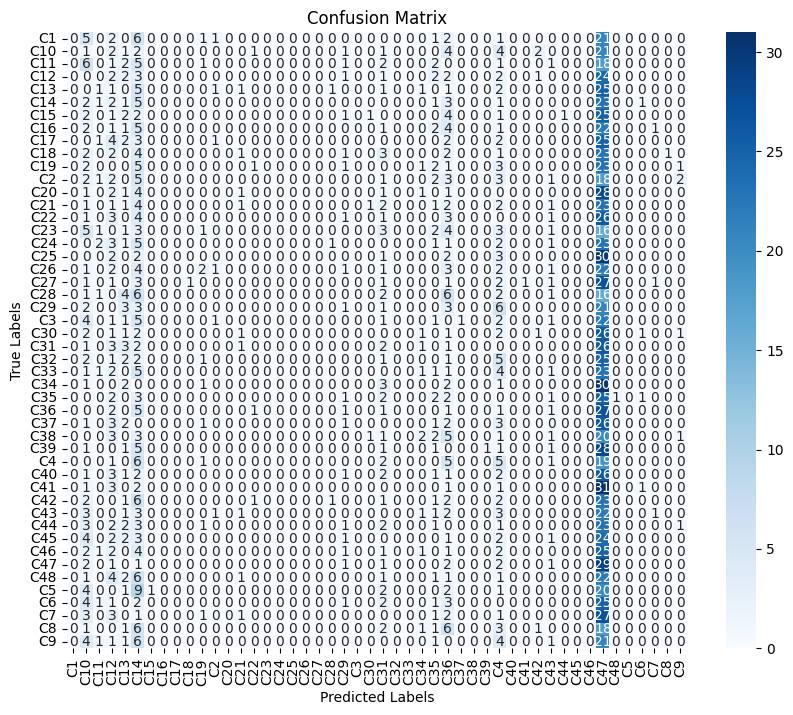

In [18]:
# Confusion Matrix


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Create a confusion matrix
conf_matrix = confusion_matrix(val_true_labels, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_class_labels, yticklabels=val_class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
